In [10]:
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pickle as pkl

from typing import List
import matplotlib.gridspec as gridspec

from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

In [8]:

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train


def subgroup_ate(
    method: str,
    features: List[int],
    y_true_train: np.ndarray,
    y_true_test: np.ndarray,
    estimated_ate_test: np.ndarray,
    iss_test: np.ndarray
) -> None:
    
    xgb_model = xgb.XGBClassifier(  
        max_depth=3,
        reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_true_train)

    y_pred = xgb_model.predict(x_test[:, features])
    y_pred_train = xgb_model.predict(x_train[:, features])
    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    auroc = metrics.roc_auc_score(y_true_test, y_pred)
        
    print("===================")
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

def feature_idx(
    method: str,
    cohort: str,
    learner: str
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_{learner}.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_{learner}.csv"
    elif method == "shap - 0 ":
        file_path = f"../results/{cohort}/shapley_value_sampling_top_5_features_{learner}.csv"
        
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist())
    
    indices  = [ x.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    
    for i in indices:
        if i > treatment_index:
            i -= 1
    return indices

In [6]:
fluid_cohort = pd.read_pickle("../data/low_bp_survival.pkl")
all_year = pd.read_csv("../data/all_year.csv", index_col=0)


fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F",
                                                            "traumatype_P",
                                                            "traumatype_other"
                                                            ])]

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns

print(names)
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=42,
                                             stratify=fluid_cohort["treated"]
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                             x_train,  
                                             y_train, 
                                             test_size=0.2, 
                                             random_state=42,
                                             stratify=x_train[:, treatment_index]
                                    )

w_train = x_train[:, treatment_index]
w_val = x_val[:, treatment_index]
w_test =  x_test[:, treatment_index]


iss_train = x_train[:, iss_index]
iss_test =  x_test[:, iss_index]

x_train = x_train[:,var_index]
x_val = x_val[:, var_index]
x_test = x_test[:, var_index]

Index(['age', 'scenegcs', 'scenefirstbloodpressure', 'scenefirstpulse',
       'scenefirstrespirationrate', 'edfirstbp', 'edfirstpulse',
       'edfirstrespirationrate', 'temps2', 'edgcs', 'causecode_ABUSE',
       'causecode_AIR', 'causecode_BIKE', 'causecode_BITES', 'causecode_CUT',
       'causecode_DROWN', 'causecode_ENVIRON', 'causecode_EXPLOSION',
       'causecode_FALL', 'causecode_GUN', 'causecode_MACHINE', 'causecode_MC',
       'causecode_MV', 'causecode_OTHER', 'causecode_PEDESTRIAN',
       'causecode_POISON', 'causecode_RAILWAY', 'causecode_SMOKE',
       'causecode_STRUCK', 'causecode_SUFFOCATIO', 'causecode_SUFFOCATION',
       'causecode_TRANSPORT', 'causecode_WATER', 'sex_M', 'traumatype_B',
       'traumatype_OTHER', 'BD', 'CFSS', 'COHB', 'CREAT', 'FIB', 'FIO2', 'HCT',
       'HGB', 'INR', 'LAC', 'NA', 'PAO2', 'PH', 'PLTS', 'PTT', 'iss'],
      dtype='object')


/tmp/ipykernel_2841231/2869625458.py:2: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("../data/all_year.csv", index_col=0)


In [9]:
results_train = pkl.load(open("../results/massive_trans/train_xlearner.pkl", "rb"))
results_test = pkl.load(open("../results/massive_trans/test_xlearner.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)
threshold = np.mean(estimated_ate_train)

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")
lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")

explainers = {
    
    "shap": feature_idx("shap","massive_trans", "xlearner"),
    "shap - 0 ": feature_idx("shap - 0 ","massive_trans" ,"xlearner"), #[temp, ph, bd, hgb, pulse ]
    "ig": feature_idx("ig","massive_trans" ,"xlearner"), #[ph, na, temp, gender, fio2 ],
    
    "clinical": [lac, inr, hgb,scenefirstbloodpressure ],
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}


print("mean ISS: ", np.mean(iss_test)*74+1)
print("original", np.sum(estimated_ate_test[w_test==1])/n)
print("original - iss", np.mean(iss_test[w_test==1])*74+1, np.mean(iss_test[w_test==0])*74+1)
print("===================================")

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
        iss_test
    )

-0.04359583797298134 0.01224235412480223
-0.044979371980935406 0.02237256661326439
['traumatype_B', 'edgcs', 'causecode_FALL', 'sex_M', 'causecode_CUT']
['temps2', 'HCT', 'NA', 'HGB', 'edfirstpulse']
['temps2', 'HCT', 'traumatype_B', 'PH', 'NA']
mean ISS:  29.1565598580524
original -0.007728684288254787
original - iss 32.176198801198794 25.356564783531073
shap - auroc 0.794240317775571
shap - ATE 0.039242999966659434
shap - 0  - auroc 0.5737835153922541
shap - 0  - ATE -0.0031156017095202676
ig - auroc 0.6503475670307846
ig - ATE 0.009749850991010594
clinical - auroc 0.5156901688182721
clinical - ATE -0.024012609621491376
full features - auroc 0.8109235352532274
full features - ATE 0.040060226552290336
random features - auroc 0.5940913604766633
random features - ATE 0.00457393794751434


In [10]:
results_train = pkl.load(open("../results/massive_trans/train_xlearner.pkl", "rb"))
results_test = pkl.load(open("../results/massive_trans/test_xlearner.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)
threshold = np.mean(estimated_ate_train)

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")
lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")

explainers = {
    
    "shap": feature_idx("shap","massive_trans", "ensemble"),
    "shap - 0 ": feature_idx("shap - 0 ","massive_trans" ,"ensemble"), #[temp, ph, bd, hgb, pulse ]
    "ig": feature_idx("ig","massive_trans" ,"ensemble"), #[ph, na, temp, gender, fio2 ],
    
    "clinical": [lac, inr, hgb,scenefirstbloodpressure ],
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}


print("mean ISS: ", np.mean(iss_test)*74+1)
print("original", np.sum(estimated_ate_test[w_test==1])/n)
print("original - iss", np.mean(iss_test[w_test==1])*74+1, np.mean(iss_test[w_test==0])*74+1)
print("===================================")

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
        iss_test
    )

-0.04359583797298134 0.01224235412480223
-0.044979371980935406 0.02237256661326439
['causecode_PEDESTRIAN', 'sex_M', 'edgcs', 'scenegcs', 'traumatype_B']
['edgcs', 'scenegcs', 'traumatype_B', 'scenefirstpulse', 'HGB']
['FIO2', 'HGB', 'sex_M', 'temps2', 'traumatype_B']
mean ISS:  29.1565598580524
original -0.007728684288254787
original - iss 32.176198801198794 25.356564783531073
shap - auroc 0.7263654419066534
shap - ATE 0.03105440185826958
shap - 0  - auroc 0.7379841112214497
shap - 0  - ATE 0.029720891329612746
ig - auroc 0.6919066534260179
ig - ATE 0.02325804521797679
clinical - auroc 0.5156901688182721
clinical - ATE -0.024012609621491376
full features - auroc 0.8109235352532274
full features - ATE 0.040060226552290336
random features - auroc 0.5857497517378352
random features - ATE 0.0009342930210170483


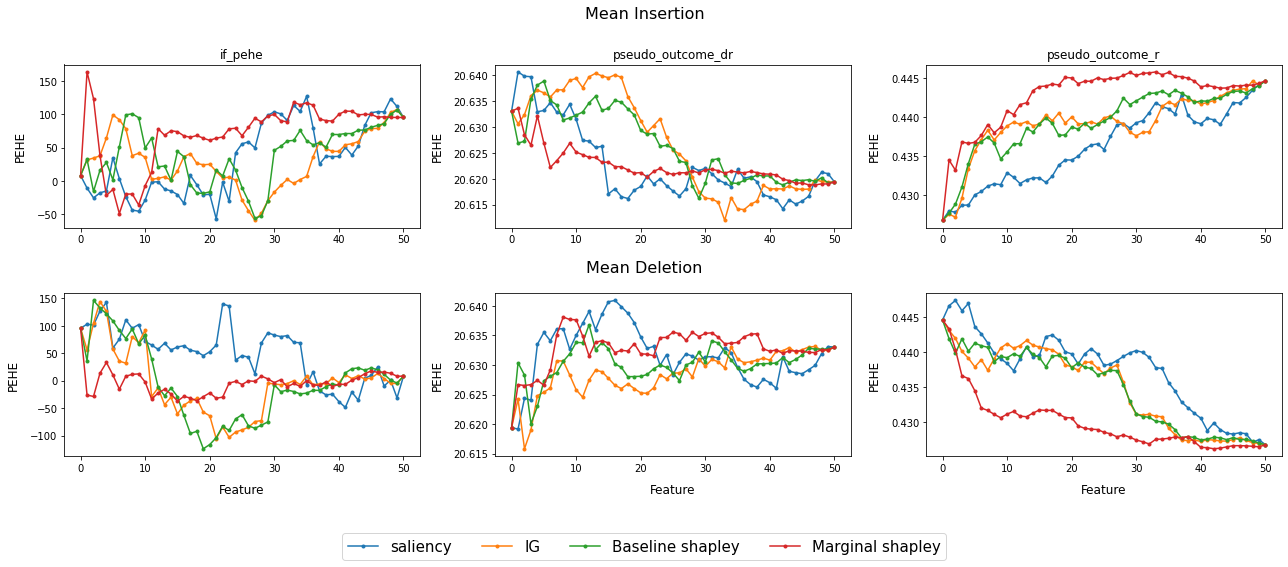

In [29]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

# Loop over the different files

seeds = [0, 1, 2,3, 4]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"../results/massive_trans/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])
            auroc_ate[exp].append(results[exp_index][4])
            
            auroc_full.append(results[exp_index][7])
            auroc_full_ate.append(results[exp_index][6])
            
            auroc_random.append(results[exp_index][9])
            auroc_random_ate.append(results[exp_index][8])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


# # Function to calculate the percentage contribution of cumulative PEHE up to nth feature relative to the total PEHE at final feature
# def calc_cumulative_contribution(n, data):
#     if n >= len(data):
#         raise ValueError(f"Feature index {n} is out of bounds for data of length {len(data)}")
#     percentage_contribution = (data[-1] - data[n] / data[-1]) * 100
#     return percentage_contribution

# # Let's say you want the cumulative contribution of PEHE when up to the 5th feature is added
# n = 4

# # Loop through each explainer and selection type
# for exp in explainers:
#     for selection_type in selection_types:
#         # Get the cumulative PEHE for each feature
#         pehe_values = np.mean(insertion_results_all[exp][selection_type], axis=0)
#         percentage_contribution = calc_cumulative_contribution(n, pehe_values)
        
#         # Print the percentage contribution of PEHE up to nth feature
#         print(f"For {exp} with {selection_type} selection:")
#         print(f"Percentage contribution of PEHE up to {n+1}th feature: {percentage_contribution}%")


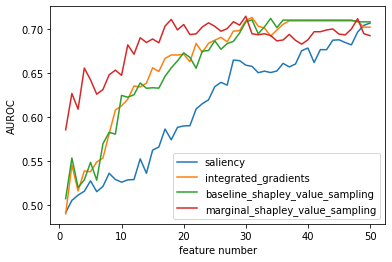

In [31]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_results

for k, v in auroc_results.items():
    
    feature_num = [i+1 for i in range(v.shape[0])]
    plt.plot(feature_num, v, label = k)

# plt.plot([i+1 for i in range(50)], np.array(auroc_random).mean(axis=0), label="random select N features")

plt.xlabel("feature number")
plt.ylabel("AUROC")
plt.legend()

auroc_results_ate = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}

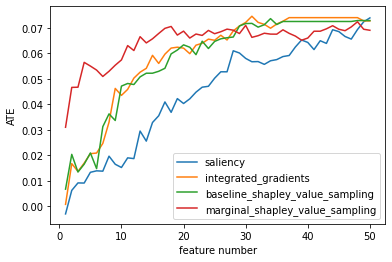

In [32]:
for k, v in auroc_results_ate.items():
    
    feature_num = [i+1 for i in range(v.shape[0])]
    plt.plot(feature_num, v, label = k)

# 
plt.xlabel("feature number")
plt.ylabel("ATE")
plt.legend()